In [46]:
import json
import os, sys

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import keras.backend as K

import wandb
from wandb.keras import WandbCallback

import support_functions as sf

## Mount drive
*directory*: directory which contains the models

In [2]:
model_directory = 'models/'
data_directory = 'calib_data/'

## Load Data

In [3]:
with open(data_directory + 'parameters.json', 'r') as f:
    parameters = json.load(f)
P_NORM = parameters['p_norm']

In [4]:
x_train, y_train = sf.load_json(data_directory + 'train.json')
x_val, y_val = sf.load_json(data_directory + 'valid.json')

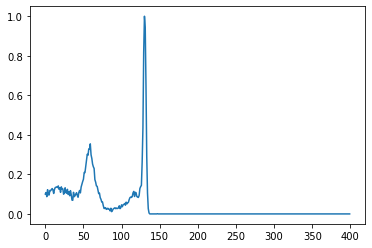

In [30]:
idx = np.random.randint(x_train.shape[0])
plt.plot( x_train[idx] )

## Loss function

In [167]:
def tot_to_energy_keras(x, a, b, c, t):
    return 1./(2*a) * ( t*a + x - b + K.sqrt((b + t*a - x)**2 - 4*a*c) )

def loss(y_true, y_pred):
    mae_loss = K.mean(K.abs(y_pred - y_true), axis=-1)

    # x = tf.cast( tf.range( 400 ), dtype=tf.float32 )
    curve_loss = 0
    for x in [10, 20, 30, 40, 50]: # range(400):
        energy_true = tot_to_energy_keras(x, *[y_true[:,idx] for idx in range(4)])
        energy_true = tf.where(tf.math.is_nan(energy_true), tf.ones_like(energy_true) * 10, energy_true)

        energy_pred = tot_to_energy_keras(x, *[y_pred[:,idx] for idx in range(4)])
        energy_pred = tf.where(tf.math.is_nan(energy_pred), tf.ones_like(energy_pred) * 10, energy_pred)
        curve_loss = K.abs(energy_true - energy_pred)
    # mae_loss += curve_loss

    return mae_loss

## Model

In [168]:
def conv_block(x,
    size=1,
    kernel_size=3,
    filter_size=4,
    strides=2,
    activation='relu',
    padding='same',
    kernel_initializer='he_normal'
):
    for _ in range( size - 1 ):
        x = keras.layers.Conv1D(filter_size,
                kernel_size=kernel_size,
                activation=activation,
                padding=padding,
                kernel_initializer=kernel_initializer
            )(x)
    x = keras.layers.Conv1D(filter_size,
        kernel_size=kernel_size,
        activation=activation,
        strides=strides,
        padding=padding,
        kernel_initializer=kernel_initializer
    )(x)
    return x

def get_model(
    blocks=3,
    kernel_size=3,
    filter_size=8,
    strides=2,
    padding='same',
    activation='relu',
    kernel_initializer='he_normal'
):
    # Input
    inp = keras.layers.Input(shape=(400, 1))
    x = inp

    # Convolutions
    for block in range(blocks):
        x = conv_block(x,
                size=3,
                kernel_size=kernel_size,
                filter_size=filter_size << block,
                strides=strides,
                padding=padding,
                activation=activation,
                kernel_initializer=kernel_initializer
            )

    # Flatten and output
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(x.shape[1] // 4, activation='relu')(x)
    x = keras.layers.Dense(4, activation='relu')(x)
    # x = keras.layers.Lambda(lambda x: x * np.asarray(P_NORM))(x)
    return keras.models.Model(inp, x)

In [169]:
model = get_model(
    blocks=5,
    kernel_size=3,
    filter_size=8,
    strides=2,
    padding='same',
    activation='relu',
    kernel_initializer='he_normal'
)
model.summary()

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 400, 1)]          0         
                                                                 
 conv1d_303 (Conv1D)         (None, 400, 8)            32        
                                                                 
 conv1d_304 (Conv1D)         (None, 400, 8)            200       
                                                                 
 conv1d_305 (Conv1D)         (None, 200, 8)            200       
                                                                 
 conv1d_306 (Conv1D)         (None, 200, 16)           400       
                                                                 
 conv1d_307 (Conv1D)         (None, 200, 16)           784       
                                                                 
 conv1d_308 (Conv1D)         (None, 100, 16)           784

In [199]:
model.compile(
    optimizer='adam',
    loss=loss,
    metrics=['mae']
)
history = model.fit(x_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(x_val, y_val)
)

Epoch 1/20
1250/1250 [==============================] - 11s 8ms/step - loss: 0.1010 - mae: 0.1010 - val_loss: 0.0887 - val_mae: 0.0887
Epoch 2/20
1250/1250 [==============================] - 10s 8ms/step - loss: 0.0854 - mae: 0.0854 - val_loss: 0.0869 - val_mae: 0.0869
Epoch 3/20
1250/1250 [==============================] - 10s 8ms/step - loss: 0.0795 - mae: 0.0795 - val_loss: 0.0806 - val_mae: 0.0806
Epoch 4/20
1250/1250 [==============================] - 10s 8ms/step - loss: 0.0763 - mae: 0.0763 - val_loss: 0.0752 - val_mae: 0.0752
Epoch 5/20
1250/1250 [==============================] - 10s 8ms/step - loss: 0.0735 - mae: 0.0735 - val_loss: 0.0764 - val_mae: 0.0764
Epoch 6/20
1250/1250 [==============================] - 10s 8ms/step - loss: 0.0720 - mae: 0.0720 - val_loss: 0.0696 - val_mae: 0.0696
Epoch 7/20
1250/1250 [==============================] - 10s 8ms/step - loss: 0.0705 - mae: 0.0705 - val_loss: 0.0703 - val_mae: 0.0703
Epoch 8/20
1250/1250 [==============================] -

In [200]:
pred = model.predict( x_val )

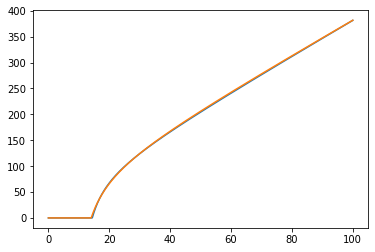

In [214]:
idx = np.random.randint( pred.shape[0] )

a, b, c, t = pred[idx]
x = np.linspace(0, 100, 1000)

# True
energy_true = sf.energy_to_tot(x, *y_val[idx] * P_NORM)
plt.plot(x, energy_true)

# Prediction
energy = sf.energy_to_tot(x, *pred[idx] * P_NORM)
plt.plot(x, energy)

## Training

In [88]:
hyperparameter_defaults = dict(
    learning_rate=1.e-3,
    epochs=10,
    blocks=3,
    strides=2,
    kernel_size=3,
    filter_size=4,
    batch_size=64,
    loss_function='mae',
    architecture='CNN'
)

In [89]:
sweep_config = {
  "name" : "calib-sweep",
  "method" : "grid",
  "parameters" : {
    "blocks" : {
        "values" : [3, 5, 7]
    },
    "filter_size" : {
        "values" : [4, 8, 16]
    }
  }
}

In [ ]:

def training():
    with wandb.init(
        project='calibration',
        config=hyperparameter_defaults
    ) as run:
        config = wandb.config

        K.clear_session()
        model = get_model(
            blocks=config.blocks,
            kernel_size=config.kernel_size,
            filter_size=config.filter_size,
            strides=config.strides,
            padding='same',
            activation='relu',
            kernel_initializer='he_normal'
        )

        adam = keras.optimizers.Adam(learning_rate=config.learning_rate)
        model.compile(optimizer=adam, loss=config.loss_function, metrics=['mae'])

        model.fit(x_train, y_train,
            epochs=config.epochs,
            batch_size=config.batch_size,
            validation_data=(x_val, y_val),
            callbacks=[WandbCallback()]
        )

sweep_id = wandb.sweep(sweep_config)
wandb.agent(sweep_id, function=training)

In [45]:
history

## Load measurement

- *MEAS_DIR*: directory containing measurements
- *MEAS_FN*: list containing names of measurement files
- *MAKE_HIST*: true, if unbinned data is used; false if already binned

Binning has to be [1, ..., 401] in steps of 1  
Binned histograms per pixel are stored in dictionary *meas_dict*, with the keys corresponding to the names in *MEAS_FN*. Every measurement contains a dictionary with the three slots (*Slot1*, *Slot2*, *Slot3*) as keys. The corresponding values are the binned histograms with a shape of *(256, 400)*.

In [ ]:
MEAS_DIR = directory + '../measurements/'
# MEAS_FN =  ['johanna/ToTMeasurement_Am_DPX38.json']
MEAS_FN = ['johanna/ToTMeasurement6None38Ikrum20_11.json']
# MEAS_FN = ['ToTMeasurement_93.json']
MAKE_HIST = True
SLOTS = [1, 3]

measurements = [np.nan_to_num( json.load(open(MEAS_DIR + fn, 'r'))) for fn in MEAS_FN]
meas_dict = {}
for m_idx, measurement in enumerate(measurements):
    print('Processing %s...' % MEAS_FN[m_idx].split('.')[0])
    histDict = {}
    for slot in ['Slot%d' % sl for sl in SLOTS]:
        if slot == 'bins':
            continue
        print(slot)
        hist = []
        for pixel in range(256):
            if MAKE_HIST:
                h, b = np.histogram(np.asarray(measurement[slot]).T[pixel], bins=np.arange(1, 402))
            else:
                h = np.asarray( measurement[slot][pixel] )
                b = np.arange(len(h))

            h = np.asarray(h, dtype=float)
            h /= float(np.max(h))
            hist.append( np.nan_to_num(h) )
        histDict[int(slot[-1])] = hist
    meas_dict[MEAS_FN[m_idx].split('.')[0]] = histDict

class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

Processing johanna/ToTMeasurement6None38Ikrum20_11...
Slot1
Slot3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


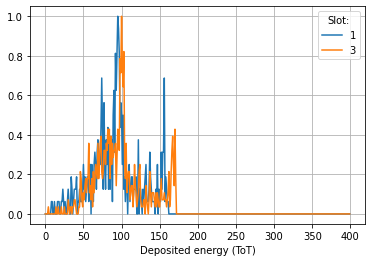

In [ ]:
PIXEL = 1
for key in meas_dict.keys():
    for slot in meas_dict[key].keys():
        plt.plot(meas_dict[key][slot][PIXEL], label=slot)
    plt.legend(title='Slot:')
    plt.grid()
    plt.xlabel('Deposited energy (ToT)')
    plt.show()

## Calibration parameter prediction

Predict the calibration parameters per pixel for the dictionary containing the measurements, *meas_dict*. Returns *outDict*, with the measurement names as keys and a dictionary for each slot as entries. These dictionaries contain lists with 256 pixel entries. Each entry is a dictionary with the parameter names as keys (*a*, *b*, *c*, *t*), containing the corresponding parameter values.  

For example:  
*outDict* = {meas_name: {'Slot1': {pixel#: {'a':, 'b':, 'c', 't'}}}

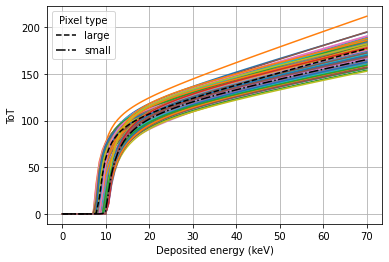

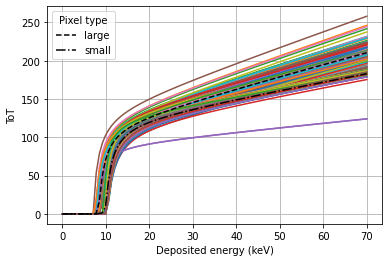

In [ ]:
# Large and small pixel indices
largePixels = np.asarray( [pixel for pixel in np.arange(256) if pixel % 16 not in [0, 1, 14, 15]] )
smallPixels = np.asarray( [pixel for pixel in np.arange(256) if pixel % 16 in [0, 1, 14, 15]] )
pixels = [largePixels, smallPixels]

# Normalisation factors of the training data. Corresponds to the used models
p_norm_large = [1.85, 125., -275., 7.5 ]
p_norm_small = [0.4, 100.0, -275., 7.5] 
p_norm = np.asarray([p_norm_large, p_norm_small])

regs = [regressor, regressor_small]

energyFit = np.linspace(0, 70, 100)
# Loop over measurements
outDict = {}
for m_key in meas_dict:
    histDict = meas_dict[m_key]
    paramDict = {}

    # Loop over slots
    for key in histDict.keys():
        m = histDict[key]
        m = np.asarray(m).reshape((len(m), -1, 1))
        
        pixelDict = {}
        sum_small, sum_large = np.zeros(len(energyFit)), np.zeros(len(energyFit))
        for idx in range(2):
            pred = regs[idx].predict([m[pixels[idx]], np.zeros((len(m[pixels[idx]]), 2))]) * p_norm[idx]
            a, b, c, t = pred.T
            for pixel_idx, pixel in enumerate(pixels[idx]):
                pixelDict[str(pixel)] = {'a': a[pixel_idx], 'b': b[pixel_idx], 'c': c[pixel_idx], 't': t[pixel_idx]}
                y_res = energyToToTSimple(energyFit, a[pixel_idx], b[pixel_idx], c[pixel_idx], t[pixel_idx])
                if pixel % 16 not in [0, 1, 14, 15]:
                    sum_large += y_res
                else:
                    sum_small += y_res
                plt.plot(energyFit, y_res)
        paramDict['Slot%d' % key] = pixelDict

        plt.plot(energyFit, sum_large / 192., label='large', ls='--', color='k')
        plt.plot(energyFit, sum_small / 64., label='small', ls='-.', color='k')
        plt.legend(title='Pixel type')
        plt.xlabel('Deposited energy (keV)')
        plt.ylabel('ToT')
        plt.grid()
        plt.show()

    outDict[m_key] = paramDict

# with open(directory + 'measurements/params_%s_Ikrum%d.json' % (titles[int(key) - 1], Ikrum), 'w') as f:
#     json.dump(outDict, f, cls=NumpyEncoder)

## Prediction evaluation

johanna/ToTMeasurement6None38Ikrum20_11


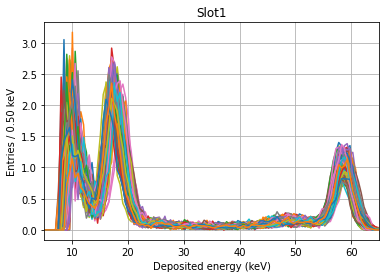

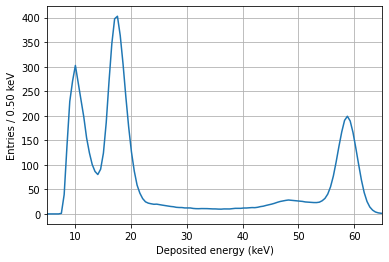

8.332815070865134 0.42707429027537147 8.285692296795126 9.524993631536788


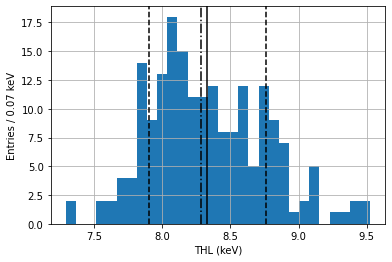

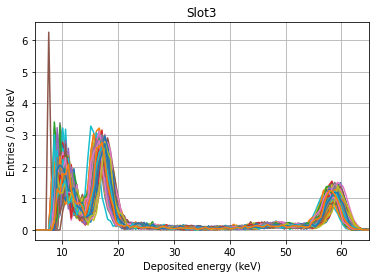

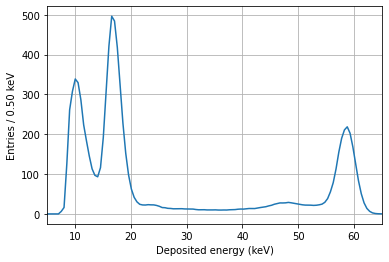

8.341509054331794 0.38181387651227816 8.315687054373022 9.545793348720865


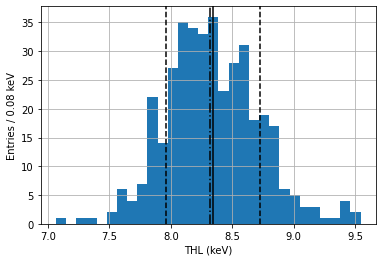

In [ ]:
import scipy.interpolate
bins_energy = np.linspace(0, 100, 200)

THL = []
for m_idx, meas in enumerate(outDict.keys()):
    print(meas)
    for slot in SLOTS:
        sum = np.zeros(len(bins_energy))
        for pixel in range(256):
            if pixel % 16 in [0, 1, 14, 15]:
                THL.append(np.nan)
                continue
            bins = np.arange(400)
            p = outDict[meas]['Slot%d' % slot]['%d' % pixel]
            a, b, c, t = p['a'], p['b'], p['c'], p['t']
            THL.append( getTHL(a, b, c, t) )
            bins_ = ToTtoEnergySimple(bins, a, b, c, t)
            # d = np.asarray(measurements[m_idx]['Slot%d' % slot][pixel]).flatten()[:-1] / np.diff(bins_)
            d = np.asarray(meas_dict[meas][slot][pixel]).flatten()[:-1] / np.diff(bins_)
            f = scipy.interpolate.interp1d(bins_[:-1], d, bounds_error=False, fill_value=0)
            plt.plot(bins_energy, f(bins_energy))
            plt.title('Slot%d' % slot)
            sum += f(bins_energy)

        # Plot single pixels
        plt.xlim(5, 65)
        plt.grid()
        plt.xlabel('Deposited energy (keV)')
        plt.ylabel('Entries / %.2f keV' % np.diff(bins_energy)[0])
        plt.savefig('per_pixel_calib.pdf', bbox_inches='tight')
        plt.show()

        # Plot sum over all pixels
        plt.plot(bins_energy, sum)
        plt.grid()
        plt.xlabel('Deposited energy (keV)')
        plt.ylabel('Entries / %.2f keV' % np.diff(bins_energy)[0])
        plt.xlim(5, 65)
        plt.savefig('all_pixels_calib.pdf', bbox_inches='tight')
        plt.show()

        # Plot THL
        h, b, c = plt.hist(THL, bins=30)
        m, std, med = np.nanmean(THL), np.nanstd(THL), np.nanmedian(THL)
        print(m, std, med, np.nanmax(THL))
        plt.axvline(m, ls='-', color='k')
        plt.axvline(med, ls='-.', color='k')
        plt.axvline(x=m + std, ls='--', color='k')
        plt.axvline(x=m - std, ls='--', color='k')

        plt.grid()
        plt.xlabel('THL (keV)')
        plt.ylabel('Entries / %.2f keV' % np.diff(b)[-1])
        plt.show()

In [ ]:
outDict.keys()

dict_keys(['johanna/ToTMeasurement6None38Ikrum20_9'])

In [ ]:
NUMS = [6, None, 38]
# NUMS = [30, None, None]
for key in outDict.keys():
    for slot in SLOTS:
        with open(directory + '../measurements/calib_params_DPX%d.json' % NUMS[slot - 1], 'w') as f:
            json.dump(outDict[key]['Slot%d' % slot], f, cls=NumpyEncoder)